In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('P36_EEG_OpenBCIEMG_IMUADS1220_EEG_EMG250Hz1.csv')

# Display the first few rows
df.head()

,Time(s),Trigger,Label,Planning,Fz,C3,Cz,C4,Pz,P07,Oz,P08,EMG_Right,EMG_Left
0,0.004,0,0,0,750000.0625,750000.06250,725363.500000,750000.06250,647769.500000,750000.0625,750000.0625,559457.125,744.737793,-1462.251099
1,0.008,0,0,0,686651.2500,275439.56250,211592.796900,570121.75000,7759.006348,542056.5000,519369.0000,-384488.125,743.374329,-1454.964478
2,0.012,0,0,0,740683.5000,60365.00000,353304.218800,75003.78906,-422467.218800,445471.0000,474656.8438,-483375.375,746.950623,-1453.623291
3,0.016,0,0,0,750000.0625,63482.62109,344934.000000,-371128.46880,-669896.000000,620954.3750,581923.5000,-750000.125,740.714478,-1459.144287
4,0.020,0,0,0,750000.0625,251675.20310,6927.520996,-452716.81250,-750000.125000,750000.0625,715442.8750,-750000.125,727.906921,-1458.183105


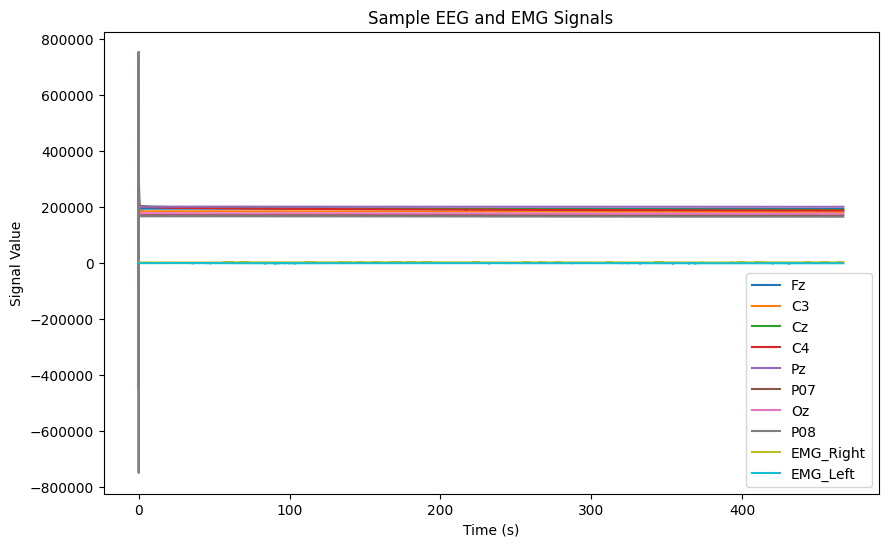

In [9]:
import matplotlib.pyplot as plt

# Plot a few EEG/EMG signals
plt.figure(figsize=(10, 6))
plt.plot(df['Time(s)'], df['Fz'], label='Fz')
plt.plot(df['Time(s)'], df['C3'], label='C3')
plt.plot(df['Time(s)'], df['Cz'], label='Cz')
plt.plot(df['Time(s)'], df['C4'], label='C4')
plt.plot(df['Time(s)'], df['Pz'], label='Pz')
plt.plot(df['Time(s)'], df['P07'], label='P07')
plt.plot(df['Time(s)'], df['Oz'], label='Oz')
plt.plot(df['Time(s)'], df['P08'], label='P08')
plt.plot(df['Time(s)'], df['EMG_Right'], label='EMG_Right')
plt.plot(df['Time(s)'], df['EMG_Left'], label='EMG_Left')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title('Sample EEG and EMG Signals')
plt.legend()
plt.show()

In [3]:
# Identify trigger transitions
df['trigger_change'] = df['Trigger'].diff() 

# Find start and end indices of trials
trial_starts = df[df['trigger_change'] == 1].index
trial_ends = df[df['trigger_change'] == -1].index

# Create a list to store trial data
trials = []
for start, end in zip(trial_starts, trial_ends):
    trial_data = df.iloc[start:end + 1][['Fz', 'C3', 'Cz', 'C4', 'Pz', 'P07', 'Oz', 'P08', 'EMG_Right', 'EMG_Left', 'Label', 'Time(s)']].copy()
    trials.append(trial_data)

# Check the number of trials
len(trials)


39

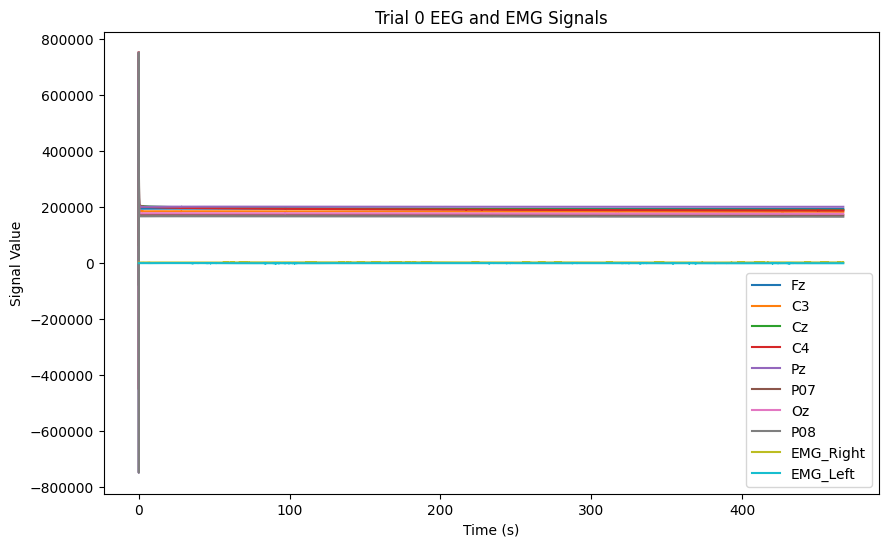

In [10]:
# Visualize the first trial
trial_0 = trials[0]
plt.figure(figsize=(10, 6))
plt.plot(df['Time(s)'], df['Fz'], label='Fz')
plt.plot(df['Time(s)'], df['C3'], label='C3')
plt.plot(df['Time(s)'], df['Cz'], label='Cz')
plt.plot(df['Time(s)'], df['C4'], label='C4')
plt.plot(df['Time(s)'], df['Pz'], label='Pz')
plt.plot(df['Time(s)'], df['P07'], label='P07')
plt.plot(df['Time(s)'], df['Oz'], label='Oz')
plt.plot(df['Time(s)'], df['P08'], label='P08')
plt.plot(df['Time(s)'], df['EMG_Right'], label='EMG_Right')
plt.plot(df['Time(s)'], df['EMG_Left'], label='EMG_Left')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title('Trial 0 EEG and EMG Signals')
plt.legend()
plt.show()

In [5]:
import numpy as np

# Function to pad trials with zeros
def pad_trial(trial, max_length):
    padded_trial = np.zeros((max_length, trial.shape[1]))
    padded_trial[:len(trial)] = trial
    return padded_trial

# Calculate the maximum length among all trials
max_length = max(len(trial) for trial in trials)

# Pad the trials
padded_trials = [pad_trial(trial[['Fz', 'C3', 'Cz', 'C4', 'Pz', 'P07', 'Oz', 'P08', 'EMG_Right', 'EMG_Left']].values, max_length) for trial in trials]

padded_trials[0].shape

(2002, 10)

In [6]:
import torch

# Convert padded trials and labels to PyTorch tensors
padded_trials_tensor = torch.tensor(np.array(padded_trials), dtype=torch.float32).unsqueeze(-1)
labels_tensor = torch.tensor([trial['Label'].iloc[0] for trial in trials], dtype=torch.long)

# Check the shape of the tensors
print("Shape of padded trials tensor:", padded_trials_tensor.shape)
print("Shape of labels tensor:", labels_tensor.shape)

Shape of padded trials tensor: torch.Size([39, 2002, 10, 1])
Shape of labels tensor: torch.Size([39])


In [7]:
from torch.utils.data import Dataset, DataLoader

class AmpcDataset(Dataset):
    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels

    def __getitem__(self, index):
        return self.trials[index], self.labels[index]

    def __len__(self):
        return len(self.trials)

# Create the dataset
dataset = AmpcDataset(padded_trials_tensor, labels_tensor)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check the first batch
for X, y in dataloader:
    print("Shape of input batch:", X.shape)
    break

Shape of input batch: torch.Size([32, 2002, 10, 1])


In [12]:
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class PSABlock(nn.Module):
    def __init__(self, in_channels):
        super(PSABlock, self).__init__()
        self.group_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=4)
        self.conv_list = nn.ModuleList([
            nn.Conv2d(in_channels // 4, in_channels // 4, kernel_size=3, padding=1),
            nn.Conv2d(in_channels // 4, in_channels // 4, kernel_size=5, padding=2),
            nn.Conv2d(in_channels // 4, in_channels // 4, kernel_size=7, padding=3),
            nn.Conv2d(in_channels // 4, in_channels // 4, kernel_size=9, padding=4)
        ])
        self.se_blocks = nn.ModuleList([SEBlock(in_channels // 4) for _ in range(4)])

    def forward(self, x):
        x = self.group_conv(x)
        x_split = torch.split(x, x.size(1) // 4, dim=1)
        outputs = []
        for x_i, conv_i, se_i in zip(x_split, self.conv_list, self.se_blocks):
            att = se_i(conv_i(x_i))
            outputs.append(x_i * att)
        return torch.cat(outputs, dim=1)

class TemporalConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalConvUnit, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x

class TimeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TimeConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 10), padding=(0, 5))
        self.unit1 = TemporalConvUnit(out_channels, out_channels)
        self.unit2 = TemporalConvUnit(out_channels, out_channels)
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.unit1(x)
        x = self.unit2(x)
        x = self.se(x)
        return x

class FreqConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FreqConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(10, 1), stride=(2, 1), padding=(5, 0))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.se(x)
        return x

class TFConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TFConvUnit, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1))
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x

class TFConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TFConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5), padding=(2, 2))
        self.unit1 = TFConvUnit(out_channels, out_channels)
        self.unit2 = TFConvUnit(out_channels, out_channels)
        self.psa = PSABlock(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.unit1(x)
        x = self.unit2(x)
        x = self.psa(x)
        return x

class SimpleAMPCNet(nn.Module):
    def __init__(self, num_classes, input_channels, target_shape):
        super(SimpleAMPCNet, self).__init__()

        self.time_conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(1, 10), padding=(0, 5)),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU()
        )

        self.freq_conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(10, 1), stride=(2, 1), padding=(5, 0)),
            nn.ReLU()
        )

        self.tf_conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU()
        )

        self.hht_conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(1, 1), padding=(0, 0)),  # Example, adjust according to HHT output
            nn.ReLU()
        )

        # Calculate flatten size using dummy input
        dummy_input = torch.randn(1, input_channels, target_shape[0], target_shape[1])
        with torch.no_grad():
            self.flatten_size = self._get_flatten_size(dummy_input)

        # Initialize the classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _get_flatten_size(self, x):
        x_time = self.time_conv(x)
        x_freq = self.freq_conv(x)
        x_tf = self.tf_conv(x)
        x_hht = self.hht_conv(x)  # Add HHT output
        x_time_flat = x_time.view(x_time.size(0), -1)
        x_freq_flat = x_freq.view(x_freq.size(0), -1)
        x_tf_flat = x_tf.view(x_tf.size(0), -1)
        x_hht_flat = x_hht.view(x_hht.size(0), -1)  # Flatten HHT output
        return x_time_flat.shape[1] + x_freq_flat.shape[1] + x_tf_flat.shape[1] + x_hht_flat.shape[1]

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x_time = self.time_conv(x)
        x_freq = self.freq_conv(x)
        x_tf = self.tf_conv(x)
        x_hht = self.hht_conv(x)  # Apply HHT convolution
        x_time_flat = x_time.view(x_time.size(0), -1)
        x_freq_flat = x_freq.view(x_freq.size(0), -1)
        x_tf_flat = x_tf.view(x_tf.size(0), -1)
        x_hht_flat = x_hht.view(x_hht.size(0), -1)  # Flatten HHT output
        concat_features = torch.cat([x_time_flat, x_freq_flat, x_tf_flat, x_hht_flat], dim=1)
        out = self.classifier(concat_features)
        return out

In [14]:
import torch.nn as nn
import torch.optim as optim
from AMPCNet import AMPCNet

# Instantiate the model
model = AMPCNet(num_classes=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss, epoch_train_acc = 0, 0
    for X, y in dataloader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        epoch_train_acc += (y_pred.argmax(1) == y).sum().item() / len(y)

    train_losses.append(epoch_train_loss / len(dataloader))
    train_accs.append(epoch_train_acc / len(dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")

Input to time_conv: torch.Size([32, 2002, 10, 1])


RuntimeError: Calculated padded input size per channel: (10 x 1). Kernel size: (1 x 10). Kernel size can't be greater than actual input size

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()